In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import joypy

from isttc.scripts.cfg_global import project_folder_path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'synthetic_dataset\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'
fig_folder = project_folder_path + 'results\\synthetic\\figures\\'

In [3]:
save_fig = False

### Load data

In [4]:
with open(dataset_folder + 'spike_trains.pkl','rb') as f:
    data = pickle.load(f)

spike_trains = data['spike_trains']
alphas = data['alphas']
fr_values = data['fr_values']
taus_ms = data['tau_ms']
duration_ms = data['duration_ms']

print(f'n spike trains {len(spike_trains)}, len {spike_trains[0][-1]/1000}, duration_ms {duration_ms}')

n spike trains 100000, len 598.8243581617338, duration_ms 600000


In [6]:
# 40 trials
with open(results_folder + 'tau_pearsonr_trial_50ms_20lags_dict.pkl', "rb") as f:
    pearsonr_trial_avg_40_dict = pickle.load(f)

with open(results_folder + 'tau_isttc_trial_concat_50ms_20lags_dict.pkl', "rb") as f:
    sttc_trial_concat_40_dict = pickle.load(f)

# 60 trials
with open(results_folder + 'tau_pearsonr_trial_50ms_20_lags_60_trials_dict.pkl', "rb") as f:
    pearsonr_trial_avg_60_dict = pickle.load(f)

with open(results_folder + 'tau_isttc_trial_concat_50ms_20lags_60_trials_dict.pkl', "rb") as f:
    sttc_trial_concat_60_dict = pickle.load(f)

# 80 trials
with open(results_folder + 'tau_pearsonr_trial_50ms_20_lags_80_trials_dict.pkl', "rb") as f:
    pearsonr_trial_avg_80_dict = pickle.load(f)

with open(results_folder + 'tau_isttc_trial_concat_50ms_20lags_80_trials_dict.pkl', "rb") as f:
    sttc_trial_concat_80_dict = pickle.load(f)

# 100 trials
with open(results_folder + 'tau_pearsonr_trial_50ms_20_lags_100_trials_dict.pkl', "rb") as f:
    pearsonr_trial_avg_100_dict = pickle.load(f)

with open(results_folder + 'tau_isttc_trial_concat_50ms_20lags_100_trials_dict.pkl', "rb") as f:
    sttc_trial_concat_100_dict = pickle.load(f)

print(f'len pearsonr_trial_avg_40_dict {len(pearsonr_trial_avg_40_dict)}')
print(f'len sttc_trial_concat_40_dict {len(sttc_trial_concat_40_dict)}')

print(f'len pearsonr_trial_avg_60_dict {len(pearsonr_trial_avg_60_dict)}')
print(f'len sttc_trial_concat_60_dict {len(sttc_trial_concat_60_dict)}')

print(f'len pearsonr_trial_avg_80_dict {len(pearsonr_trial_avg_80_dict)}')
print(f'len sttc_trial_concat_80_dict {len(sttc_trial_concat_80_dict)}')

print(f'len pearsonr_trial_avg_100_dict {len(pearsonr_trial_avg_100_dict)}')
print(f'len sttc_trial_concat_100_dict {len(sttc_trial_concat_100_dict)}')

len pearsonr_trial_avg_40_dict 100000
len sttc_trial_concat_40_dict 100000
len pearsonr_trial_avg_60_dict 100000
len sttc_trial_concat_60_dict 100000
len pearsonr_trial_avg_80_dict 100000
len sttc_trial_concat_80_dict 100000
len pearsonr_trial_avg_100_dict 100000
len sttc_trial_concat_100_dict 100000


### Make summary dfs

In [7]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [8]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [9]:
def get_trials_plot_df(trial_dict_, method_, n_iteration_=None):
    records = []
    for unit_id, data in trial_dict_.items():
        taus = data['taus']
        acfs = data['acf']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[unit_id]
            taus_to_iter = [(taus[idx], acfs[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(taus, acfs)

        for tau_dict, acf_array in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'tau': tau_dict['tau'],
                'tau_lower': tau_dict['tau_lower'],
                'tau_upper': tau_dict['tau_upper'],
                'fit_r_squared': tau_dict['fit_r_squared'],
                'decline_150_250': calculate_acf_decline_flag(acf_array, start_idx=1, end_idx=4),
                'method': method_,
            })

    df = pd.DataFrame.from_records(records)
    df['tau_ms'] = df['tau'] * 50

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}')

    return df

In [10]:
def get_df_for_ntrials(pearsonr_trial_avg_dict, sttc_trial_concat_dict, n_trials):
    # for trial based measures one realization of trials is taken
    random_trials_impl = np.zeros(len(sttc_trial_concat_40_dict)).astype(int)
    
    pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg', random_trials_impl)
    sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat', random_trials_impl)
    
    pearsontr_trial_avg_plot_df['fr'] = fr_values
    pearsontr_trial_avg_plot_df['alpha'] = alphas
    pearsontr_trial_avg_plot_df['tau_ms_true'] = taus_ms
    pearsontr_trial_avg_plot_df['tau_diff_abs'] = np.abs(pearsontr_trial_avg_plot_df['tau_ms'] - pearsontr_trial_avg_plot_df['tau_ms_true'])
    pearsontr_trial_avg_plot_df['tau_diff_rel'] = pearsontr_trial_avg_plot_df['tau_diff_abs'] / pearsontr_trial_avg_plot_df['tau_ms_true'] * 100
    pearsontr_trial_avg_plot_df['n_trials'] = n_trials
    
    sttc_trial_concat_plot_df['fr'] = fr_values
    sttc_trial_concat_plot_df['alpha'] = alphas
    sttc_trial_concat_plot_df['tau_ms_true'] = taus_ms
    sttc_trial_concat_plot_df['tau_diff_abs'] = np.abs(sttc_trial_concat_plot_df['tau_ms'] - sttc_trial_concat_plot_df['tau_ms_true'])
    sttc_trial_concat_plot_df['tau_diff_rel'] = sttc_trial_concat_plot_df['tau_diff_abs'] / sttc_trial_concat_plot_df['tau_ms_true'] * 100
    sttc_trial_concat_plot_df['n_trials'] = n_trials

    # check for NaNs and for a long df remove rows with NaNs (if for a unit one method failed than remove it)
    rows_with_nans_pearsonr_df = pearsontr_trial_avg_plot_df[pearsontr_trial_avg_plot_df.isna().any(axis=1)]
    n_rows_with_nan_pearsonr = len(rows_with_nans_pearsonr_df)
    print(f'N rows with NaNs {n_rows_with_nan_pearsonr}')
    
    rows_with_nans_isttc_concat_df = sttc_trial_concat_plot_df[sttc_trial_concat_plot_df.isna().any(axis=1)]
    n_rows_with_nan_isttc_concat = len(rows_with_nans_isttc_concat_df)
    print(f'N rows with NaNs {n_rows_with_nan_isttc_concat}')
    
    pearsonr_nan_unit_ids = rows_with_nans_pearsonr_df['unit_id'].values
    sttc_concat_nan_unit_ids = rows_with_nans_isttc_concat_df['unit_id'].values
    
    unit_ids_nan_union = set(pearsonr_nan_unit_ids).union(sttc_concat_nan_unit_ids)
    print(f'N rows in unit_ids_nan_union {len(unit_ids_nan_union)}')
    
    # take rows without NaNs
    pearsonr_sans_nans_plot_df = pearsontr_trial_avg_plot_df[~pearsontr_trial_avg_plot_df['unit_id'].isin(unit_ids_nan_union)]
    sttc_concat_sans_nans_plot_df = sttc_trial_concat_plot_df[~sttc_trial_concat_plot_df['unit_id'].isin(unit_ids_nan_union)]
    
    print(f'len pearsonr {len(pearsonr_sans_nans_plot_df)}, len sttc_concat {len(sttc_concat_sans_nans_plot_df)}')

    # check for negative R-square
    rows_with_negr_pearsonr_df = pearsonr_sans_nans_plot_df.query('fit_r_squared < 0')
    n_rows_with_negr_pearsonr = len(rows_with_negr_pearsonr_df)
    print(f'N rows with neg R {n_rows_with_negr_pearsonr}')
    
    rows_with_negr_isttc_concat_df = sttc_concat_sans_nans_plot_df.query('fit_r_squared < 0')
    n_rows_with_negr_isttc_concat = len(rows_with_negr_isttc_concat_df)
    print(f'N rows with neg R {n_rows_with_negr_isttc_concat}')
    
    pearsonr_negr_unit_ids = rows_with_negr_pearsonr_df['unit_id'].values
    isttc_concat_negr_unit_ids = rows_with_negr_isttc_concat_df['unit_id'].values
    
    unit_ids_negr_union = set(pearsonr_negr_unit_ids).union(isttc_concat_negr_unit_ids)
    print(f'N rows in unit_ids_negr_union {len(unit_ids_negr_union)}')
    
    pearsonr_sans_negr_plot_df = pearsonr_sans_nans_plot_df[~pearsonr_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
    sttc_concat_sans_negr_plot_df = sttc_concat_sans_nans_plot_df[~sttc_concat_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
    
    pearsonr_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(pearsonr_sans_negr_plot_df['tau_diff_rel'])
    sttc_concat_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(sttc_concat_sans_negr_plot_df['tau_diff_rel'])
    
    print(f'len pearsonr {len(pearsonr_sans_negr_plot_df)}, len sttc_concat {len(sttc_concat_sans_negr_plot_df)}')

    return pearsonr_sans_negr_plot_df, sttc_concat_sans_negr_plot_df
    # return pearsontr_trial_avg_plot_df, sttc_trial_concat_plot_df # temp return to get long df for inclusion stuff

In [11]:
pearsonr_sans_negr_plot_40_df, sttc_concat_sans_negr_plot_40_df = get_df_for_ntrials(pearsonr_trial_avg_40_dict, sttc_trial_concat_40_dict, 40)

N rows with NaNs 12393
N rows with NaNs 12393
N rows with NaNs 0
N rows in unit_ids_nan_union 12393
len pearsonr 87607, len sttc_concat 87607
N rows with neg R 4201
N rows with neg R 4295
N rows in unit_ids_negr_union 6000
len pearsonr 81607, len sttc_concat 81607


In [12]:
pearsonr_sans_negr_plot_60_df, sttc_concat_sans_negr_plot_60_df = get_df_for_ntrials(pearsonr_trial_avg_60_dict, sttc_trial_concat_60_dict, 60)

N rows with NaNs 8373
N rows with NaNs 8373
N rows with NaNs 0
N rows in unit_ids_nan_union 8373
len pearsonr 91627, len sttc_concat 91627
N rows with neg R 3284
N rows with neg R 3351
N rows in unit_ids_negr_union 4731
len pearsonr 86896, len sttc_concat 86896


In [13]:
pearsonr_sans_negr_plot_80_df, sttc_concat_sans_negr_plot_80_df = get_df_for_ntrials(pearsonr_trial_avg_80_dict, sttc_trial_concat_80_dict, 80)

N rows with NaNs 6228
N rows with NaNs 6228
N rows with NaNs 0
N rows in unit_ids_nan_union 6228
len pearsonr 93772, len sttc_concat 93772
N rows with neg R 2676
N rows with neg R 2748
N rows in unit_ids_negr_union 3852
len pearsonr 89920, len sttc_concat 89920


In [14]:
pearsonr_sans_negr_plot_100_df, sttc_concat_sans_negr_plot_100_df = get_df_for_ntrials(pearsonr_trial_avg_100_dict, sttc_trial_concat_100_dict, 100)

N rows with NaNs 4941
N rows with NaNs 4941
N rows with NaNs 0
N rows in unit_ids_nan_union 4941
len pearsonr 95059, len sttc_concat 95059
N rows with neg R 2253
N rows with neg R 2329
N rows in unit_ids_negr_union 3259
len pearsonr 91800, len sttc_concat 91800


In [15]:
tau_plot_long_df = pd.concat([pearsonr_sans_negr_plot_40_df, 
                              sttc_concat_sans_negr_plot_40_df, 
                              pearsonr_sans_negr_plot_60_df, 
                              sttc_concat_sans_negr_plot_60_df,
                              pearsonr_sans_negr_plot_80_df, 
                              sttc_concat_sans_negr_plot_80_df,
                              pearsonr_sans_negr_plot_100_df, 
                              sttc_concat_sans_negr_plot_100_df])
tau_plot_long_df['log_tau_ms'] = np.log10(tau_plot_long_df['tau_ms'])
tau_plot_long_df.reset_index(inplace=True, drop=True)

print(f'len tau_plot_long_df {len(tau_plot_long_df)}')

tau_plot_long_df.head(3)

len tau_plot_long_df 700446


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,n_trials,tau_diff_rel_log10,log_tau_ms
0,0,5.054998,3.814326,6.295671,0.972005,True,pearsonr_trial_avg,252.749919,7.741821,0.851099,150.923515,101.826404,67.468879,40,1.829103,2.402691
1,1,2.020436,1.463506,2.577366,0.944998,True,pearsonr_trial_avg,101.021800,4.394396,0.858098,147.947233,46.925433,31.717682,40,1.501301,2.004415
2,2,79.998685,-668.898176,828.895547,0.773955,False,pearsonr_trial_avg,3999.934263,8.587393,0.528805,267.002290,3732.931973,1398.089874,40,3.145535,3.602053


In [16]:
# tau_plot_long_df.to_pickle(results_folder + 'tau_plot_long_var_trials_with_nans_df.pkl')

### Export for stats

In [17]:
#tau_plot_long_df.to_csv(results_folder + 'tau_plot_long_trials_parametric_df.csv')

### Plots

In [18]:
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_concat = '#955da2' 

colors = [color_pearson_trail_avg, color_sttc_trail_concat]

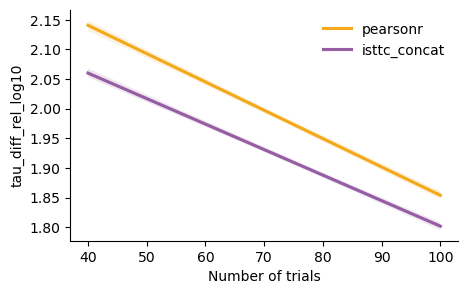

In [19]:
# just to check, I plot the same as predicted values from the model
fig, axes = plt.subplots(1,1, figsize=(5, 3), sharey=False)

sns.regplot(x='n_trials', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "pearsonr_trial_avg"'),
            scatter=None, ax=axes, 
            label='pearsonr', color=color_pearson_trail_avg)
sns.regplot(x='n_trials', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "sttc_trial_concat"'),
            scatter=None, ax=axes, 
            label='isttc_concat', color=color_sttc_trail_concat)
axes.legend(frameon=False)
axes.set_xlabel('Number of trials')

# for ax in axes.flat:
#     ax.set_ylabel('Log10 diff(IT, \nground truth) (ms)')

sns.despine()

In [20]:
tau_plot_long_df.groupby(by=['method', 'n_trials'], as_index=False)['tau_diff_rel'].describe()

,method,n_trials,count,mean,std,min,25%,50%,75%,max
0,pearsonr_trial_avg,40,81607.0,168510.392107,592752.745812,0.001624,29.075542,58.133369,99.005005,1.092559e+07
1,pearsonr_trial_avg,60,86896.0,131315.117256,522629.774633,0.002591,24.504884,50.526343,96.682895,1.026665e+07
2,pearsonr_trial_avg,80,89920.0,112800.799509,472537.538495,0.005346,22.175655,45.816083,91.686038,1.122556e+07
3,pearsonr_trial_avg,100,91800.0,98880.266220,445580.159158,0.001085,20.145632,42.442148,84.405779,9.354699e+06
4,sttc_trial_concat,40,81607.0,140888.251296,539082.141678,0.000946,27.665342,55.099314,97.457964,9.082123e+06
5,sttc_trial_concat,60,86896.0,111992.959599,476040.448446,0.000449,23.388885,47.802849,92.984911,1.004950e+07
6,sttc_trial_concat,80,89920.0,98882.351718,440610.092305,0.001040,20.771024,43.529645,85.780297,9.584269e+06
7,sttc_trial_concat,100,91800.0,85308.500094,407256.237672,0.000878,19.013134,40.319083,79.380054,1.035824e+07


In [22]:
# intervals for error plots
intervals = {
    '+-100':   (0,   100),
    '+-75':  (0,  75),
    '+-50':  (0,  50),
    '+-25':  (0,  25),
}

tau_3methods_df = tau_plot_long_df[['unit_id', 'method', 'n_trials', 'tau_ms_true', 'tau_ms', 'tau_diff_abs',
       'tau_diff_rel', 'tau_diff_rel_log10', 'log_tau_ms']].copy()
tau_3methods_df.reset_index(inplace=True, drop=True)

df = tau_3methods_df.copy()
rows = []
for method, sub in df.groupby(by=['method','n_trials']):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_diff_rel'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)
tau_3methods_error_df = pd.DataFrame(rows).set_index('method')

# make long df
tau_3methods_error_df = tau_3methods_error_df.reset_index()
tau_3methods_error_long_df = tau_3methods_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)

tau_3methods_error_long_df[['method','n_trials']] = pd.DataFrame(
    tau_3methods_error_long_df['method'].tolist(),
    index=tau_3methods_error_long_df.index
)
tau_3methods_error_long_df = tau_3methods_error_long_df.rename(columns={'interval':'error_interval'})
tau_3methods_error_long_df = tau_3methods_error_long_df[['method','n_trials','error_interval','percentage']]

In [23]:
tau_3methods_error_long_df

,method,n_trials,error_interval,percentage
0,pearsonr_trial_avg,40,+-100,75.105077
1,pearsonr_trial_avg,60,+-100,78.039265
2,pearsonr_trial_avg,80,+-100,79.741993
3,pearsonr_trial_avg,100,+-100,81.117647
4,sttc_trial_concat,40,+-100,77.547269
5,sttc_trial_concat,60,+-100,79.962254
6,sttc_trial_concat,80,+-100,81.473532
7,sttc_trial_concat,100,+-100,82.643791
8,pearsonr_trial_avg,40,+-75,61.411399
9,pearsonr_trial_avg,60,+-75,66.377048


In [24]:
# prep for heatmaps
# ACF
pearsonr_trial_avg = tau_3methods_error_long_df[
    tau_3methods_error_long_df['method']=='pearsonr_trial_avg'
]
pearsonr_trial_avg_pivot = pearsonr_trial_avg.pivot(
    index='n_trials',
    columns='error_interval',
    values='percentage'
)

# ISTTC
sttc_trial_concat = tau_3methods_error_long_df[
    tau_3methods_error_long_df['method']=='sttc_trial_concat'
]
sttc_trial_concat_pivot = sttc_trial_concat.pivot(
    index='n_trials',
    columns='error_interval',
    values='percentage'
)

diff_pivot_pearsonr_concat = pearsonr_trial_avg_pivot - sttc_trial_concat_pivot 

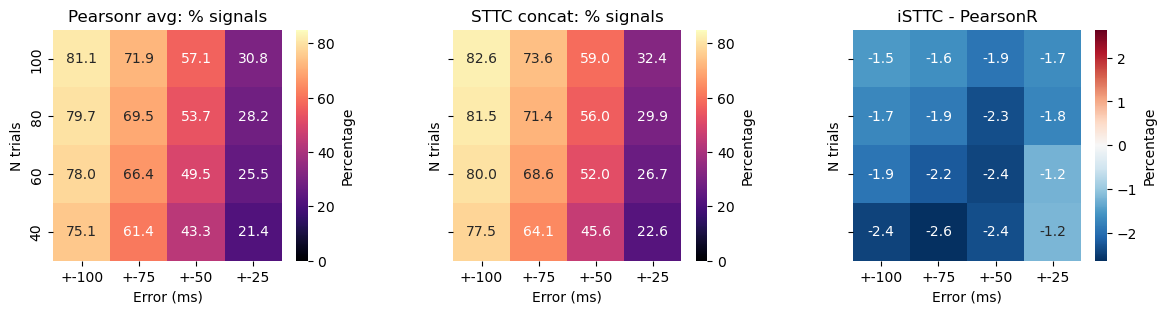

In [25]:
col_order = ['+-100', '+-75', '+-50', '+-25']

row_order = sorted(diff_pivot_pearsonr_concat.index, reverse=True)

pearsonr_trial_avg_ordered  = pearsonr_trial_avg_pivot.reindex(index=row_order, columns=col_order)
sttc_trial_concat_ordered  = sttc_trial_concat_pivot.reindex(index=row_order, columns=col_order)
diff_pivot_pearsonr_concat_pivot_ordered  = diff_pivot_pearsonr_concat.reindex(index=row_order, columns=col_order)

# plot ACF heatmap
fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

diff_limit = np.max([np.abs(diff_pivot_pearsonr_concat_pivot_ordered.min().min()), 
                     np.abs(diff_pivot_pearsonr_concat_pivot_ordered.max().max())])

norm = TwoSlopeNorm(vcenter=0, vmin=-diff_limit, vmax=diff_limit)
#norm = TwoSlopeNorm(vcenter=0)

sns.heatmap(
    pearsonr_trial_avg_ordered,
    cmap="magma", vmin=0, vmax=85,
    cbar_kws={'label': 'Percentage'}, 
    annot=True, fmt=".1f",
    ax=axes[0]
)
axes[0].set_title("Pearsonr avg: % signals")

sns.heatmap(
    sttc_trial_concat_ordered,
    cmap="magma", vmin=0, vmax=85,
    cbar_kws={'label': 'Percentage'}, 
    annot=True, fmt=".1f",
    ax=axes[1]
)
axes[1].set_title('STTC concat: % signals')

sns.heatmap(
    diff_pivot_pearsonr_concat_pivot_ordered,
    cmap="RdBu_r", 
    norm=norm,
    cbar_kws={'label': 'Percentage'}, 
    annot=True, fmt=".1f",
    ax=axes[2]
)
axes[2].set_title('iSTTC - PearsonR')

for ax in axes.flat:
    ax.set_xlabel('Error (ms)')
    ax.set_ylabel('N trials')
    
if save_fig:
    plt.savefig(fig_folder + 'taus_dataset_n_trial_var_p_vs_concat_parametric_heatmaps.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_dataset_n_trial_var_p_vs_concat_parametric_heatmaps.svg' , bbox_inches='tight')

In [26]:
heat_limit_max = np.max([np.abs(pearsonr_trial_avg_ordered.min().min()), 
                     np.abs(pearsonr_trial_avg_ordered.max().max()), 
                     np.abs(sttc_trial_concat_ordered.min().min()), 
                     np.abs(sttc_trial_concat_ordered.max().max()),])
heat_limit_max

np.float64(82.64379084967321)

In [27]:
heat_limit_min = np.min([np.abs(pearsonr_trial_avg_ordered.min().min()), 
                     np.abs(pearsonr_trial_avg_ordered.max().max()), 
                     np.abs(sttc_trial_concat_ordered.min().min()), 
                     np.abs(sttc_trial_concat_ordered.max().max()),])
heat_limit_min

np.float64(21.354785741419242)